In [1]:
# Files in data/ must be downloaded from https://doi.org/10.5281/zenodo.10932490
graph_A:str = 'data/pggb_vs_mgc/15_yeast_mgc_CASBJU01_chr_1.gfa'
graph_B:str = 'data/pggb_vs_mgc/15_yeast_pggb_chr_1.gfa'
# Files in temp/* will be created during the execution of the notebook
edition_file: str = 'temp/yeast_edit.json'
variants_file_A:str = "temp/cactus.vcf" # path to a vcf for graph A
variants_intersect:str = "temp/intersect.vcf" # path to a vcf for graph A
variants_file_B:str = "temp/pggb.vcf" # path to a vcf for graph B
variants_filter_A:str = "temp/cactus.filter.vcf" # path to a vcf for graph A
variants_filter_B:str = "temp/pggb.filter.vcf" # path to a vcf for graph B
private_variants_file_A:str = 'temp/cactus.private.vcf'
private_variants_file_B:str = 'temp/pggb.private.vcf'
reference:list[str] = ['CASBJU01'] # choosing a reference to plot against (note: CASBJT01 contains some NNNNNN... and CASBJU01 is the mgc ref) 
trf_file:str = f'temp/YEAST_{reference[0]}.bed'
reference_fasta:str = f'temp/{reference[0]}.fa'
intersect_trf_A:str = "temp/intersect_trf_A.vcf"
intersect_trf_B:str = "temp/intersect_trf_B.vcf"
chromosom:str = '1'
sampling:int = 200

In [2]:
# Colorblind-friendly palette
colors:dict[str,str] = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
}

In [3]:
from json import load
from matplotlib import pyplot as plt
from numpy import nan,percentile
from pgGraphs import Graph
from os import system
from seaborn import regplot
from pandas import DataFrame
from scipy import stats
from itertools import pairwise
from Bio import SeqIO
from matplotlib import rc
from statistics import mean

In [4]:
font = {'size': 16}
rc('font', **font)

# Creating mandatory files to compare graphs

In [5]:
# First, we compute edition to be sure to have a list of breakpoints
system(f'pancat edit {graph_A} {graph_B} -o {edition_file}')

# Then, we compute variants file
system(f'vg deconstruct -e -a -p "{reference[0]}#{reference[0]}" {graph_A} > {variants_file_A}') # format for raw cactus files > "seq000#{reference[0]}"
system(f'vg deconstruct -e -a -p "{reference[0]}" {graph_B} > {variants_file_B}') # format for pggb files

[07/30/2024 11:34:26 AM] Loaded graph data/pggb_vs_mgc/15_yeast_mgc_CASBJU01_chr_1.gfa in memory
Paths of Graph_A CASBIT01, CASBIW01, CASBIZ01, CASBJG01, CASBJH01, CASBJI01, CASBJJ01, CASBJL01, CASBJM01, CASBJN01, CASBJQ01, CASBJS01, CASBJT01, CASBJU01, CASBJV01
[07/30/2024 11:34:26 AM] Loaded graph data/pggb_vs_mgc/15_yeast_pggb_chr_1.gfa in memory
Paths of Graph_B CASBIT01, CASBIW01, CASBIZ01, CASBJG01, CASBJH01, CASBJI01, CASBJJ01, CASBJL01, CASBJM01, CASBJN01, CASBJQ01, CASBJS01, CASBJT01, CASBJU01, CASBJV01
[07/30/2024 11:34:26 AM] Computing edition for graphs on single thread
PATH SELECTION: {'CASBJL01', 'CASBJG01', 'CASBJJ01', 'CASBJT01', 'CASBIZ01', 'CASBJH01', 'CASBJV01', 'CASBJM01', 'CASBJU01', 'CASBJQ01', 'CASBJN01', 'CASBIT01', 'CASBIW01', 'CASBJI01', 'CASBJS01'}
[07/30/2024 11:34:26 AM] Saving results in temp/yeast_edit.json
[07/30/2024 11:34:26 AM] Job terminated sucessfully!
func:'perform_edition' args:[(), {'gfa_A': 'data/pggb_vs_mgc/15_yeast_mgc_CASBJU01_chr_1.gfa', 'g

0

# Analysis of tandem repeats

We have to create the file with `trf`, then convert it to `bed`.
Code to transform the file to bed can be found at https://github.com/hdashnow/TandemRepeatFinder_scripts/blob/master/TRFdat_to_bed.py

In [6]:
# We can intersect the two variants files
system(f'bedtools intersect -a {variants_file_A} -b {variants_file_B} > {variants_intersect}')

# However the results we need is the intersection of both files and the bed file of tandem repeats
system(f'bedtools intersect -a {variants_file_A} -b {trf_file} > {intersect_trf_A}')
system(f'bedtools intersect -a {variants_file_B} -b {trf_file} > {intersect_trf_B}')

0

We need to analyse sequence composition. Counts of unique small `k-mers` with binned overlapping windows may help to analyse complexity of regions.

# Loading files in memory

In [7]:
editions:dict[str,list] = load(open(edition_file,'r',encoding='utf-8'))

cactus_gfa:Graph = Graph(graph_A)
pggb_gfa:Graph = Graph(graph_B)

Showing the different path names

In [8]:
cactus_gfa.paths.keys()

dict_keys(['CASBIT01', 'CASBIW01', 'CASBIZ01', 'CASBJG01', 'CASBJH01', 'CASBJI01', 'CASBJJ01', 'CASBJL01', 'CASBJM01', 'CASBJN01', 'CASBJQ01', 'CASBJS01', 'CASBJT01', 'CASBJU01', 'CASBJV01'])

# Performing comparison

First, we will look at the distribution of variants along the graph.
- We need to get the length of the reference sequence for the x-axis of the graph
- Then, we can plot by position the variants from the according vcfs

In [9]:
# We can take any of the two as they have the same content in sequences
reference_length:int = sum([cactus_gfa.segments[x]['length'] for x,_ in cactus_gfa.paths[reference[0].upper()]['path']])
print(f'Length of the reference is {reference_length} bp.')

ratios:float = sampling/reference_length

Length of the reference is 222424 bp.


We open the variants files

In [10]:
file_A_variants:dict[str,tuple] = dict()
with open(variants_file_A,'r') as vcf_A:
    for line in vcf_A:
        if not line.startswith('#'):
            l:list[str] = line.split()
            file_A_variants[l[1]]=(l[3],l[4])
            
file_B_variants:dict[str,tuple] = dict()
with open(variants_file_B,'r') as vcf_B:
    for line in vcf_B:
        if not line.startswith('#'):
            l:list[str] = line.split()
            file_B_variants[l[1]]=(l[3],l[4])

We split the variants in batches (percentage of the sequence)

In [11]:


# Comptage des variants dans chacun des graphes (variants totaux)
counts_A:list[int] = [0 for _ in range(sampling)]
counts_B:list[int] = [0 for _ in range(sampling)]
counts_A_sup_2:list[int] = [0 for _ in range(sampling)]
counts_B_sup_2:list[int] = [0 for _ in range(sampling)]
counts_A_sup_50:list[int] = [0 for _ in range(sampling)]
counts_B_sup_50:list[int] = [0 for _ in range(sampling)]

# Comptage des variants privés
p_counts_A:list[int] = [0 for _ in range(sampling)]
p_counts_B:list[int] = [0 for _ in range(sampling)]
p_counts_A_sup_2:list[int] = [0 for _ in range(sampling)]
p_counts_B_sup_2:list[int] = [0 for _ in range(sampling)]
p_counts_A_sup_50:list[int] = [0 for _ in range(sampling)]
p_counts_B_sup_50:list[int] = [0 for _ in range(sampling)]

for pos in file_A_variants.keys():
    is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
    counts_A[int(int(pos)*ratios)] += 1
    if not is_common_variant:
        p_counts_A[int(int(pos)*ratios)] += 1
    if any([len(x) >= 50 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
        counts_A_sup_50[int(int(pos)*ratios)] += 1
        if not is_common_variant:
            p_counts_A_sup_50[int(int(pos)*ratios)] += 1
    if any([len(x) >= 2 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
        counts_A_sup_2[int(int(pos)*ratios)] += 1
        if not is_common_variant:
            p_counts_A_sup_2[int(int(pos)*ratios)] += 1

for pos in file_B_variants.keys():
    is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
    counts_B[int(int(pos)*ratios)] += 1
    if not is_common_variant:
        p_counts_B[int(int(pos)*ratios)] += 1
    if any([len(x) >= 50 for x in [file_B_variants[pos][0]] + file_B_variants[pos][1].split(',')]):
        counts_B_sup_50[int(int(pos)*ratios)] += 1
        if not is_common_variant:
            p_counts_B_sup_50[int(int(pos)*ratios)] += 1
    if any([len(x) >= 2 for x in [file_B_variants[pos][0]] + file_B_variants[pos][1].split(',')]):
        counts_B_sup_2[int(int(pos)*ratios)] += 1
        if not is_common_variant:
            p_counts_B_sup_2[int(int(pos)*ratios)] += 1


We plot variations along the reference

Then, we compute editions along the reference. We can only display editions on reference, sadly.

In [12]:
sampling:int = 200
counts_editions:list[int] = [0 for _ in range(sampling)]

counts_merges:list[int] = [0 for _ in range(sampling)]
counts_splits:list[int] = [0 for _ in range(sampling)]
ratios:float = sampling/reference_length

for merge in editions[reference[0].upper()]['merges']:
    counts_editions[int(float(merge[0])*ratios)] += 1

for split in editions[reference[0].upper()]['splits']:
    counts_editions[int(int(split[0])*ratios)] += 1
    
for merge in editions[reference[0].upper()]['merges']:
    counts_merges[int(float(merge[0])*ratios)] += 1

for split in editions[reference[0].upper()]['splits']:
    counts_splits[int(int(split[0])*ratios)] += 1

In [13]:
counts_nodes_cactus:list[int] = [0 for _ in range(sampling)]
counts_nodes_pggb:list[int] = [0 for _ in range(sampling)]

pos_counter: int = 0
for x,_ in cactus_gfa.paths[reference[0].upper()]['path']:
    counts_nodes_cactus[int(float(pos_counter)*ratios)] +=1
    pos_counter += cactus_gfa.segments[x]['length']
    
pos_counter: int = 0
for x,_ in pggb_gfa.paths[reference[0].upper()]['path']:
    counts_nodes_pggb[int(float(pos_counter)*ratios)] +=1
    pos_counter += pggb_gfa.segments[x]['length']

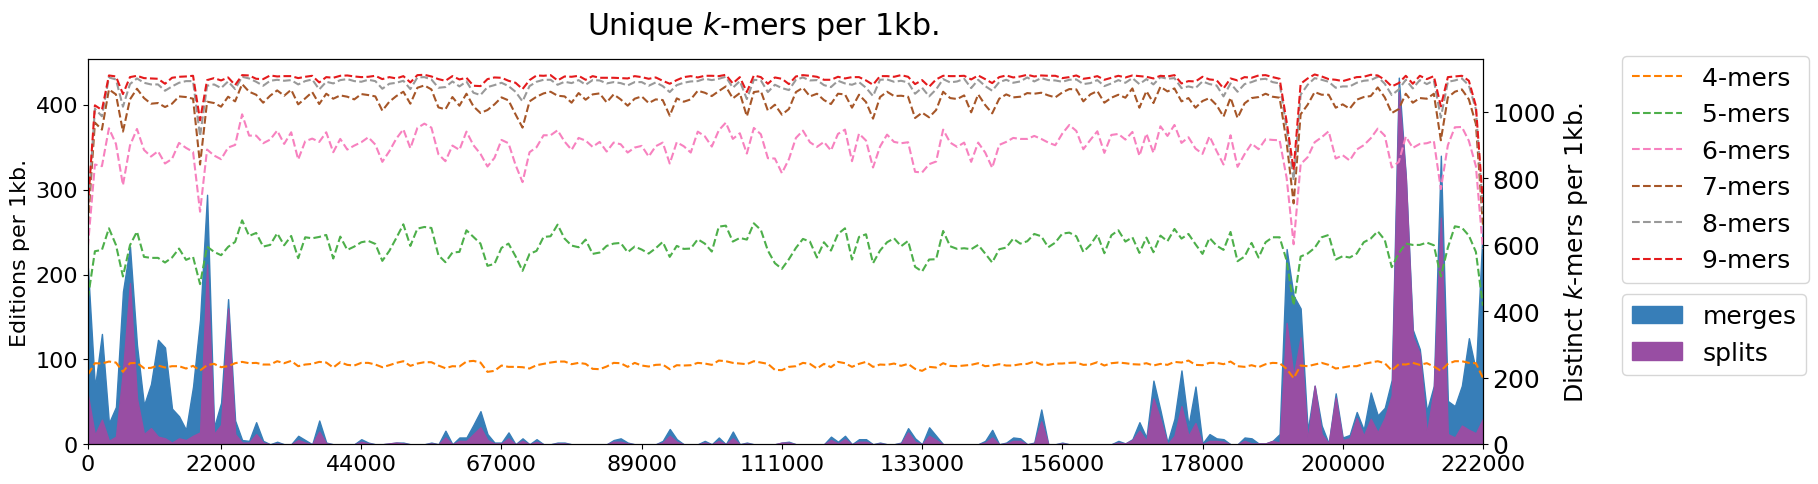

<Figure size 640x480 with 0 Axes>

In [14]:
fig, ax = plt.subplots(figsize=(18,5))
# Setting font parameters
plt.rcParams.update({'font.size': 18})

ax.fill_between(list(range(sampling)),counts_editions, color=colors['blue'], label='merges')
ax.fill_between(list(range(sampling)),counts_splits, color=colors['purple'], label='splits')
ax.set_ylabel(f'Editions per {round((reference_length/200)/1000)}kb.')
ax.set_ylim(bottom=0)
#ax.set_xticklabels([round(__/ratios) if not __%20 else '' for __ in range(sampling)])
ax.legend(loc=(1.1,.18))

axb = ax.twinx()

fasta_sequences = SeqIO.parse(open(reference_fasta),'fasta')
for fasta in fasta_sequences:
    sequence:str = str(fasta.seq)
    seq_len:int = len(sequence)
    
fig.suptitle(f'Unique $k$-mers per {round((seq_len/200)/1000)}kb.')

for ind,ksize in enumerate(range(4,10)):

    kmers:list = [set() for _ in range(sampling)]
    ratios:float = sampling/seq_len
    for i in range(seq_len-ksize):
        kmers[int(int(i)*ratios)].add(sequence[i:i+ksize])

    axb.plot([len(x) for x in kmers],color=[y for x,y in colors.items() if x not in ['blue','purple']][ind],linestyle='dashed', label=f'{ksize}-mers ')

#plt.axhline(percentile(counts_editions,75), color=colors['gray']) 

axb.set_xticks([__-1 if __!=0 else 0 for __ in range(sampling+2) if not __%20])
axb.set_xticklabels([int(round(__/ratios,-3)) for __ in range(sampling+2) if not __%20 ])
axb.set_ylabel(f'Distinct $k$-mers per {round((reference_length/200)/1000)}kb.')
axb.legend(loc=(1.1,.42))
axb.set_xlim(left=0,right=sampling-1)
axb.set_ylim(bottom=0)
plt.savefig("figures/unique_kmers_along_reference.png", bbox_inches='tight')
plt.show()
plt.clf()

# Corellograms between distinct k-mers and edition counts per bin

Text(0.5, 0, 'Editions')

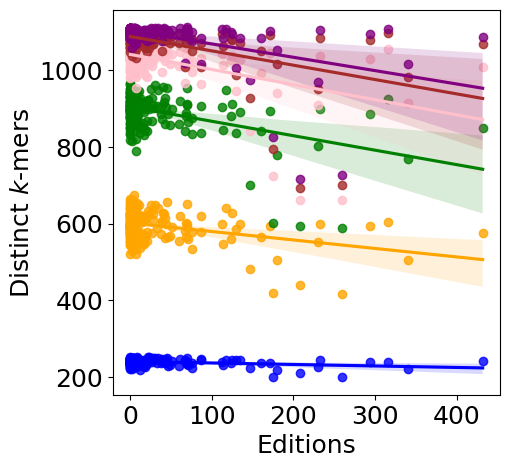

In [15]:
axb.plot([len(x) for x in kmers],color=list(colors.keys())[ind],linestyle='dashed', label=f'{ksize}-mers')

fig, ax = plt.subplots(figsize=(5,5))

mean_value = percentile(counts_editions,0)
top_values = [i for i,val in enumerate(counts_editions) if val >= mean_value]

for ind,ksize in enumerate(range(4,10)):

    kmers:list = [set() for _ in range(sampling)]
    ratios:float = sampling/seq_len
    for i in range(seq_len-ksize):
        kmers[int(int(i)*ratios)].add(sequence[i:i+ksize])

    regplot(x=[counts_editions[i] for i in top_values], y=[len(kmers[i]) for i in top_values], ax=ax, color=list(colors.keys())[ind], label=f'{ksize}-mers')

#ax.set_title(f"Total: r={round(stats.pearsonr(df_ve['average_nodes'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['average_nodes'], df_ve['edition_count'])[1]:.2e}")

ax.set_ylabel('Distinct $k$-mers')
ax.set_xlabel('Editions')

#plt.savefig("figures/correlograms_nodes.png", bbox_inches='tight')

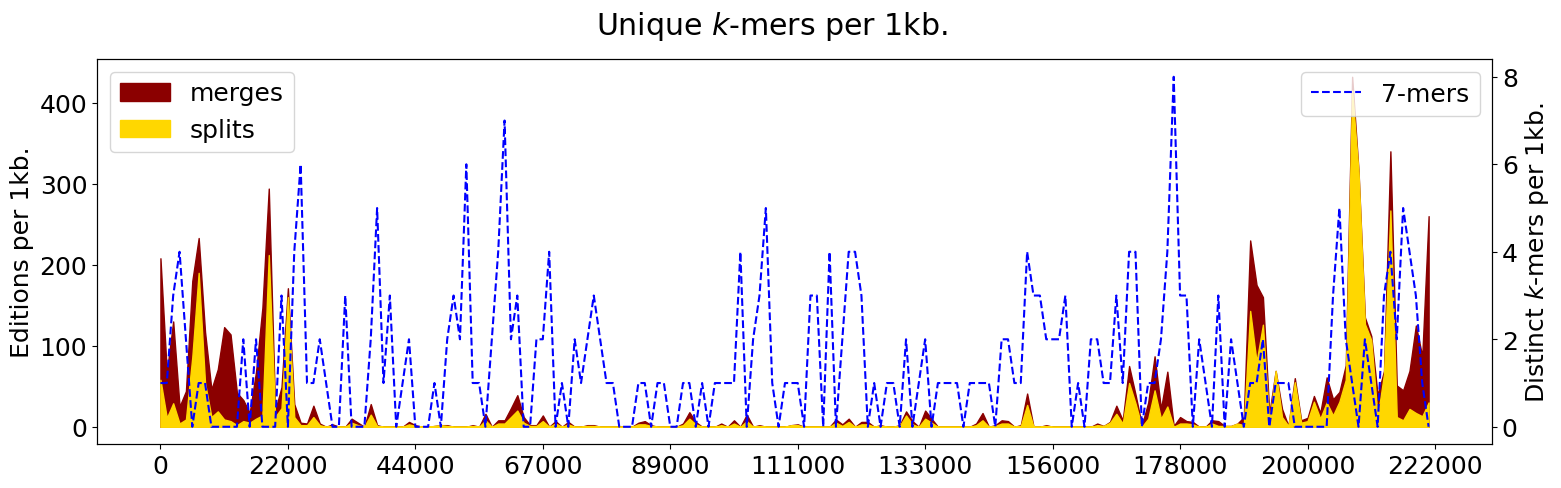

<Figure size 640x480 with 0 Axes>

In [16]:
from collections import Counter

fig, ax = plt.subplots(figsize=(18,5))

ax.fill_between(list(range(sampling)),counts_editions, color= "darkred", label='merges')
ax.fill_between(list(range(sampling)),counts_splits, color= "gold", label='splits')
ax.set_ylabel(f'Editions per {round((seq_len/200)/1000)}kb.')
#ax.set_xticklabels([round(__/ratios) if not __%20 else '' for __ in range(sampling)])
ax.legend(loc='upper left')

axb = ax.twinx()


fig.suptitle(f'Unique $k$-mers per {round((seq_len/200)/1000)}kb.')

for ind,ksize in enumerate([7]):
    kmers:list = [set() for _ in range(sampling)]
    all_kmers:list = list()
    ratios:float = sampling/seq_len
    for i in range(seq_len-ksize):
        kmers[int(int(i)*ratios)].add(sequence[i:i+ksize])
        all_kmers.append(sequence[i:i+ksize])

    kset:Counter = Counter(all_kmers)
    axb.plot([sum([1 for a in x if kset[a]==1]) for x in kmers],color=list(colors.keys())[ind],linestyle='dashed', label=f'{ksize}-mers')

axb.set_xticks([__ for __ in range(sampling+1) if not __%20])
axb.set_xticklabels([int(round(__/ratios,-3)) for __ in range(sampling+1) if not __%20 ])
axb.set_ylabel(f'Distinct $k$-mers per {round((seq_len/200)/1000)}kb.')
axb.legend(loc='upper right')

#plt.savefig("figures/unique_kmers_along_reference.png", bbox_inches='tight')
plt.show()
plt.clf()

# Editions vs microsat

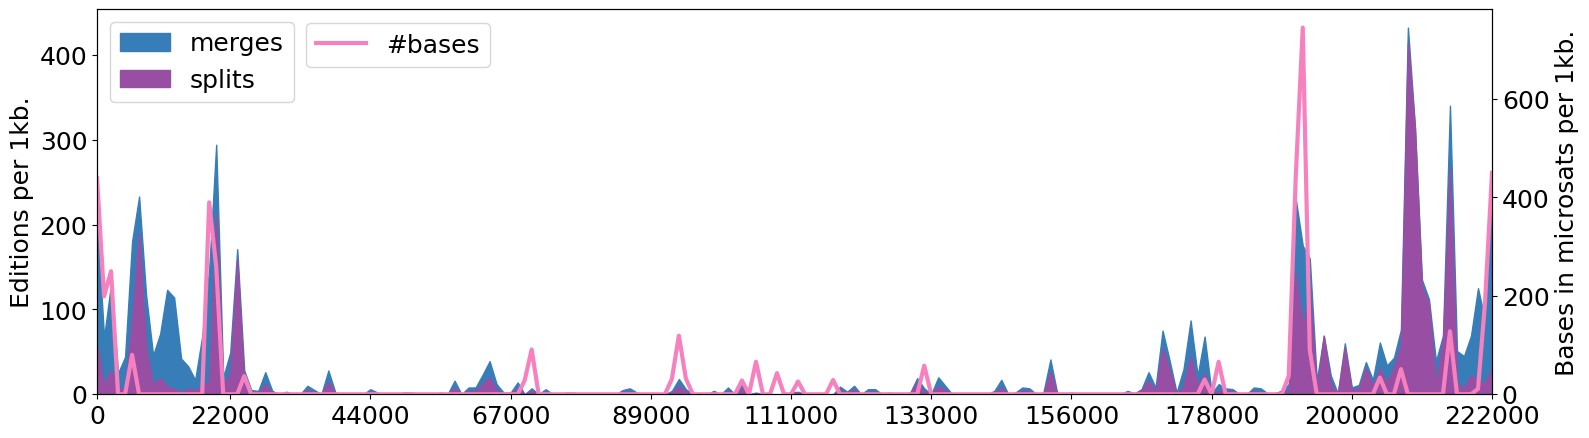

<Figure size 640x480 with 0 Axes>

In [17]:
microsat:list = [set() for _ in range(sampling)]
ratios:float = sampling/reference_length
# Setting font parameters
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(18,5))

ax.fill_between(list(range(sampling)),counts_editions, color=colors['blue'], label='merges')
ax.fill_between(list(range(sampling)),counts_splits, color=colors['purple'], label='splits')
ax.set_ylabel(f'Editions per {round((reference_length/200)/1000)}kb.')
#ax.set_xticklabels([round(__/ratios) if not __%20 else '' for __ in range(sampling)])
ax.legend(loc='upper left')
ax.set_xlim(left=0,right=sampling-1)
ax.set_ylim(bottom=0)
axb = ax.twinx()

#fig.suptitle(f'Bases involved in microsats per {round((seq_len/200)/1000)}kb.')


with open(trf_file,'r',encoding='utf-8') as bedreader:
        for line in bedreader:
                datas:list[str] = line.strip().split('\t')
                for y in range(int(datas[1]),int(datas[2])):
                        microsat[int(int(y)*ratios)].add(y)

axb.plot([len(x) for x in microsat],color=colors['pink'], label=f'#bases',linewidth=3)
axb.set_xticks([__-1 if __!=0 else 0 for __ in range(sampling+2) if not __%20])
axb.set_xticklabels([int(round(__/ratios,-3)) for __ in range(sampling+2) if not __%20 ])
axb.set_ylabel(f'Bases in microsats per {round((reference_length/200)/1000)}kb.')
axb.legend(loc=(.15,.85))
axb.set_xlim(left=0,right=sampling-1)
axb.set_ylim(bottom=0)
plt.savefig("figures/unique_kmers_along_reference.png", bbox_inches='tight')
plt.show()
plt.clf()

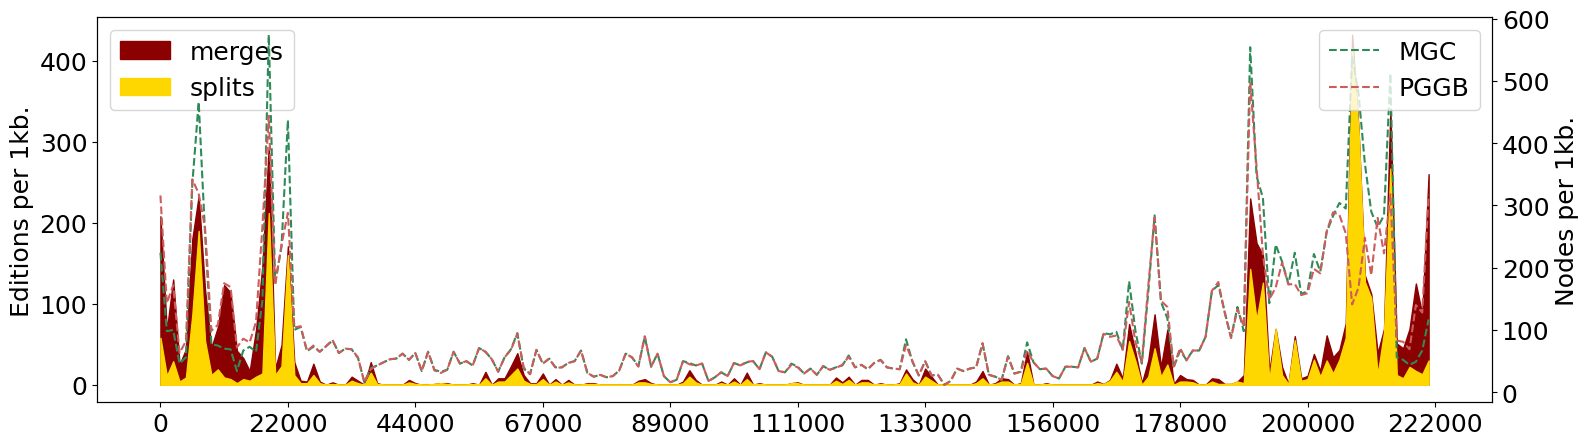

<Figure size 640x480 with 0 Axes>

In [18]:
fig, ax = plt.subplots(figsize=(18,5))
#fig.suptitle(f"Distribution of variants between graphs from MGC and PGGB for chromosom {chromosom}")
#fig.supylabel(f'Variants per {round((reference_length/200)/1000)}kb.')
ax.fill_between(list(range(sampling)),counts_editions, color= "darkred", label='merges')
ax.fill_between(list(range(sampling)),counts_splits, color= "gold", label='splits')
ax.set_ylabel(f'Editions per {round((reference_length/200)/1000)}kb.')
#ax.set_xticklabels([round(__/ratios) if not __%20 else '' for __ in range(sampling)])
ax.legend(loc='upper left')
axb = ax.twinx()
axb.set_ylabel(f'Nodes per {round((reference_length/200)/1000)}kb.')
axb.set_xticks([__ for __ in range(sampling+1) if not __%20])
axb.set_xticklabels([int(round(__/ratios,-3)) for __ in range(sampling+1) if not __%20 ])
axb.plot(counts_nodes_cactus,color='seagreen',linestyle='dashed', label='MGC')
axb.plot(counts_nodes_pggb,color='indianred',linestyle='dashed', label='PGGB')
axb.legend(loc='upper right')

plt.savefig("figures/editions_nodes_along_reference.png", bbox_inches='tight')
plt.show()
plt.clf()

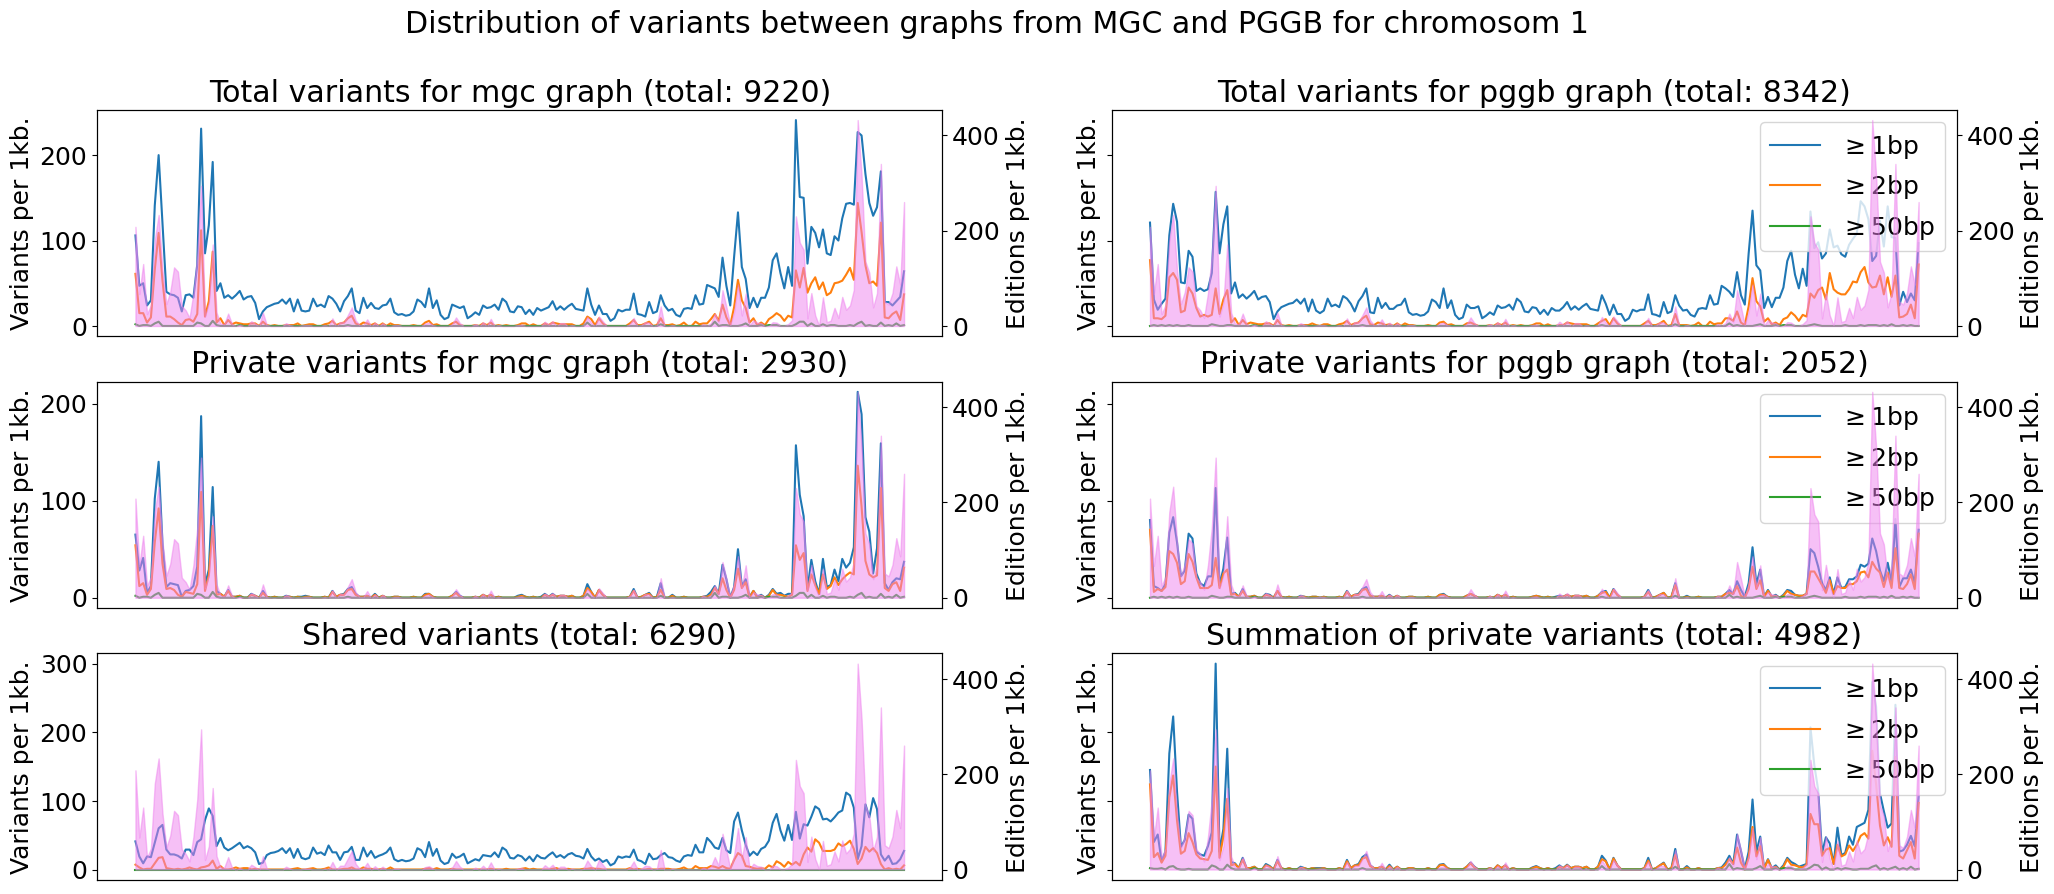

<Figure size 640x480 with 0 Axes>

In [19]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, sharex=True, sharey='row', figsize=(24,10))
fig.suptitle(f"Distribution of variants between graphs from MGC and PGGB for chromosom {chromosom}")

#fig.supylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

alpha = 0.5

for axs in (ax1, ax2, ax3, ax4, ax5, ax6):
    __ = axs.twinx()
    __.fill_between(list(range(sampling)),counts_editions, color= "violet",alpha= alpha)
    __.set_ylabel(f'Editions per {round((reference_length/200)/1000)}kb.')
    axs.set_xticks([])
    axs.set_ylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

ax1.set_title(f"Total variants for mgc graph (total: {sum(counts_A)})")
ax1.plot(counts_A)
ax1.plot(counts_A_sup_2)
ax1.plot(counts_A_sup_50)


ax2.set_title(f"Total variants for pggb graph (total: {sum(counts_B)})")
ax2.plot(counts_B, label='$\geq$1bp')
ax2.plot(counts_B_sup_2, label='$\geq$2bp')
ax2.plot(counts_B_sup_50, label='$\geq$50bp')

ax2.legend(loc='upper right')

ax3.set_title(f"Private variants for mgc graph (total: {sum(p_counts_A)})")
ax3.plot(p_counts_A)
ax3.plot(p_counts_A_sup_2)
ax3.plot(p_counts_A_sup_50)

ax4.set_title(f"Private variants for pggb graph (total: {sum(p_counts_B)})")
ax4.plot(p_counts_B, label='$\geq$1bp')
ax4.plot(p_counts_B_sup_2, label='$\geq$2bp')
ax4.plot(p_counts_B_sup_50, label='$\geq$50bp')

ax4.legend(loc='upper right')

ax5.set_title(f"Shared variants (total: {sum(counts_A)-sum(p_counts_A)})")
ax5.plot([counts_A[i] - p_counts_A[i] for i in range(sampling)])
ax5.plot([counts_A_sup_2[i] - p_counts_A_sup_2[i] for i in range(sampling)])
ax5.plot([counts_A_sup_50[i] - p_counts_A_sup_50[i] for i in range(sampling)])

ax6.set_title(f"Summation of private variants (total: {sum(p_counts_A)+sum(p_counts_B)})")
ax6.plot([p_counts_A[i]+ p_counts_B[i] for i in range(sampling)], label='$\geq$1bp')
ax6.plot([p_counts_A_sup_2[i]+ p_counts_B_sup_2[i] for i in range(sampling)], label='$\geq$2bp')
ax6.plot([p_counts_A_sup_50[i] +p_counts_B_sup_50[i] for i in range(sampling)], label='$\geq$50bp')

ax6.legend(loc='upper right')

plt.savefig("figures/baseline_profile.png", bbox_inches='tight')
plt.show()
plt.clf()

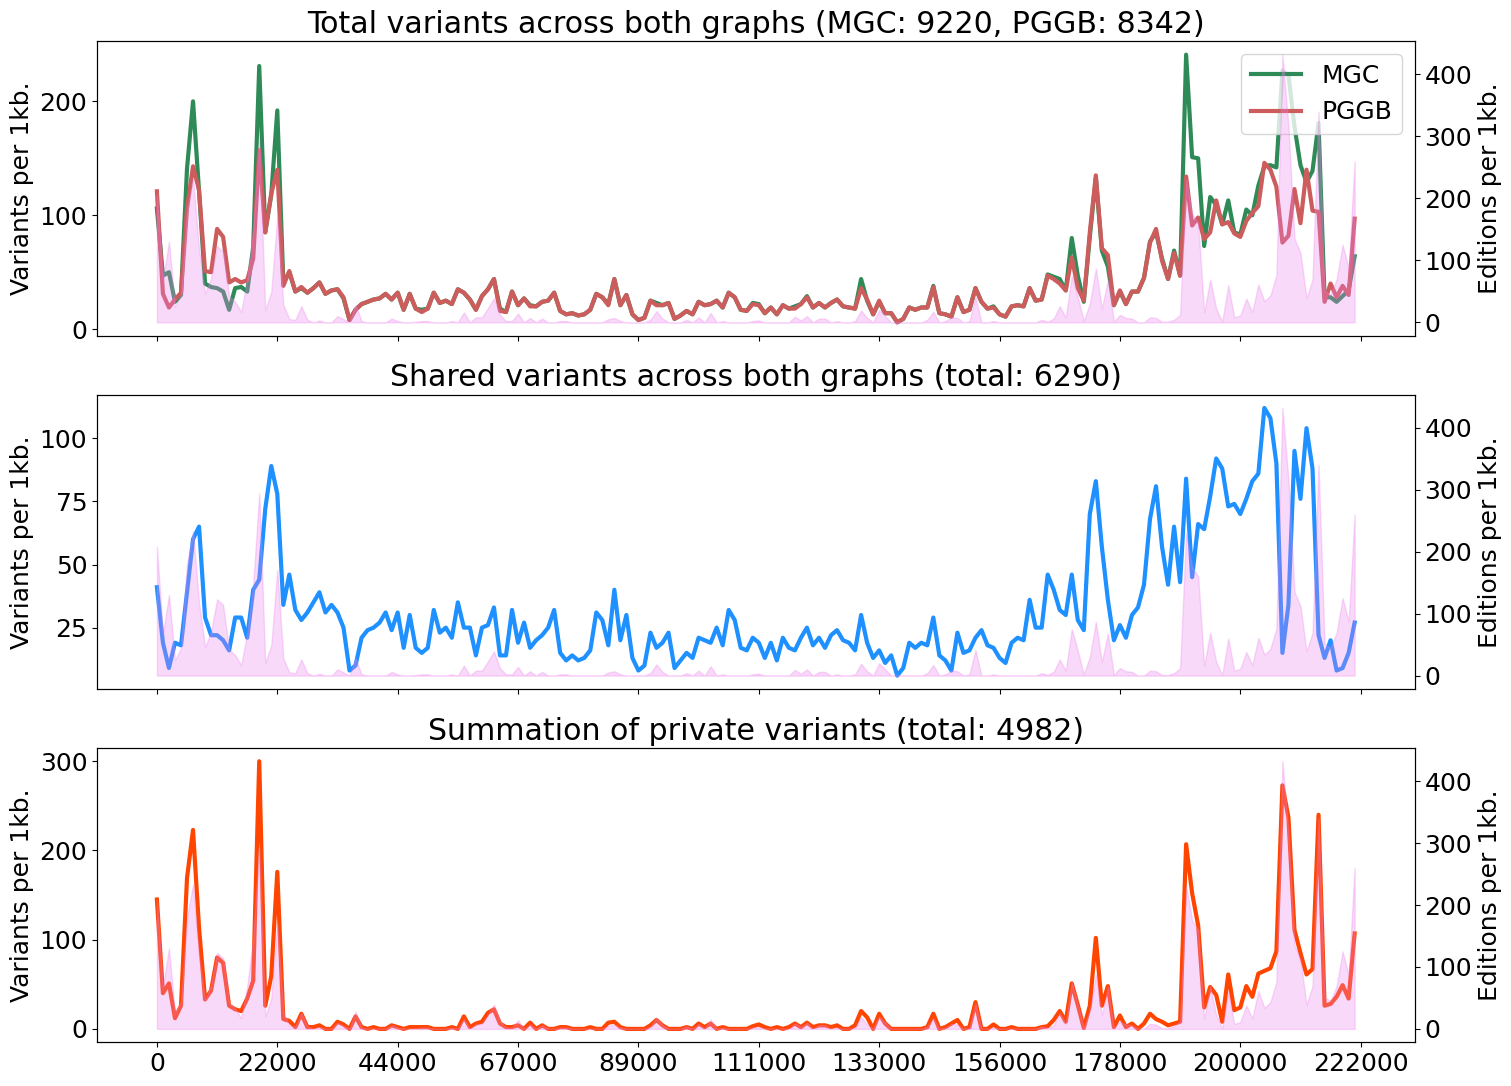

<Figure size 640x480 with 0 Axes>

In [20]:
fig, (ax2, ax5, ax6) = plt.subplots(3,1, sharex=True, sharey='row', figsize=(17,13))

#fig.supylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

alpha = 0.3

for axs in (ax2, ax5, ax6):
    __ = axs.twinx()
    __.fill_between(list(range(sampling)),counts_editions, color= "violet",alpha=alpha)
    __.set_ylabel(f'Editions per {round((reference_length/200)/1000)}kb.')
    axs.set_xticks([])
    axs.set_ylabel(f'Variants per {round((reference_length/200)/1000)}kb.')


ax2.set_title(f"Total variants across both graphs (MGC: {sum(counts_A)}, PGGB: {sum(counts_B)})")
ax2.plot(counts_A, label='MGC', color='seagreen', linewidth=3)
ax2.plot(counts_B, label='PGGB', color='indianred', linewidth=3)

ax2.legend(loc='upper right')

ax5.set_title(f"Shared variants across both graphs (total: {sum(counts_A)-sum(p_counts_A)})")
ax5.plot([counts_A[i] - p_counts_A[i] for i in range(sampling)], label='$\geq$1bp', color='dodgerblue', linewidth=3)
#ax5.plot([counts_A_sup_2[i] - p_counts_A_sup_2[i] for i in range(sampling)], label='$\geq$2bp')
#ax5.plot([counts_A_sup_50[i] - p_counts_A_sup_50[i] for i in range(sampling)], label='$\geq$50bp')

#ax5.legend(loc='upper right')

ax6.set_title(f"Summation of private variants (total: {sum(p_counts_A)+sum(p_counts_B)})")
ax6.plot([p_counts_A[i]+ p_counts_B[i] for i in range(sampling)], label='$\geq$1bp', color='orangered', linewidth=3)
#ax6.plot([p_counts_A_sup_2[i]+ p_counts_B_sup_2[i] for i in range(sampling)], label='$\geq$2bp')
#ax6.plot([p_counts_A_sup_50[i] +p_counts_B_sup_50[i] for i in range(sampling)], label='$\geq$50bp')
ax6.set_xticks([__ for __ in range(sampling+1) if not __%20])
ax6.set_xticklabels([int(round(__/ratios,-3)) for __ in range(sampling+1) if not __%20 ])

#ax6.legend(loc='upper right')

plt.savefig("figures/baseline_profile_supp.png", bbox_inches='tight')
plt.show()
plt.clf()

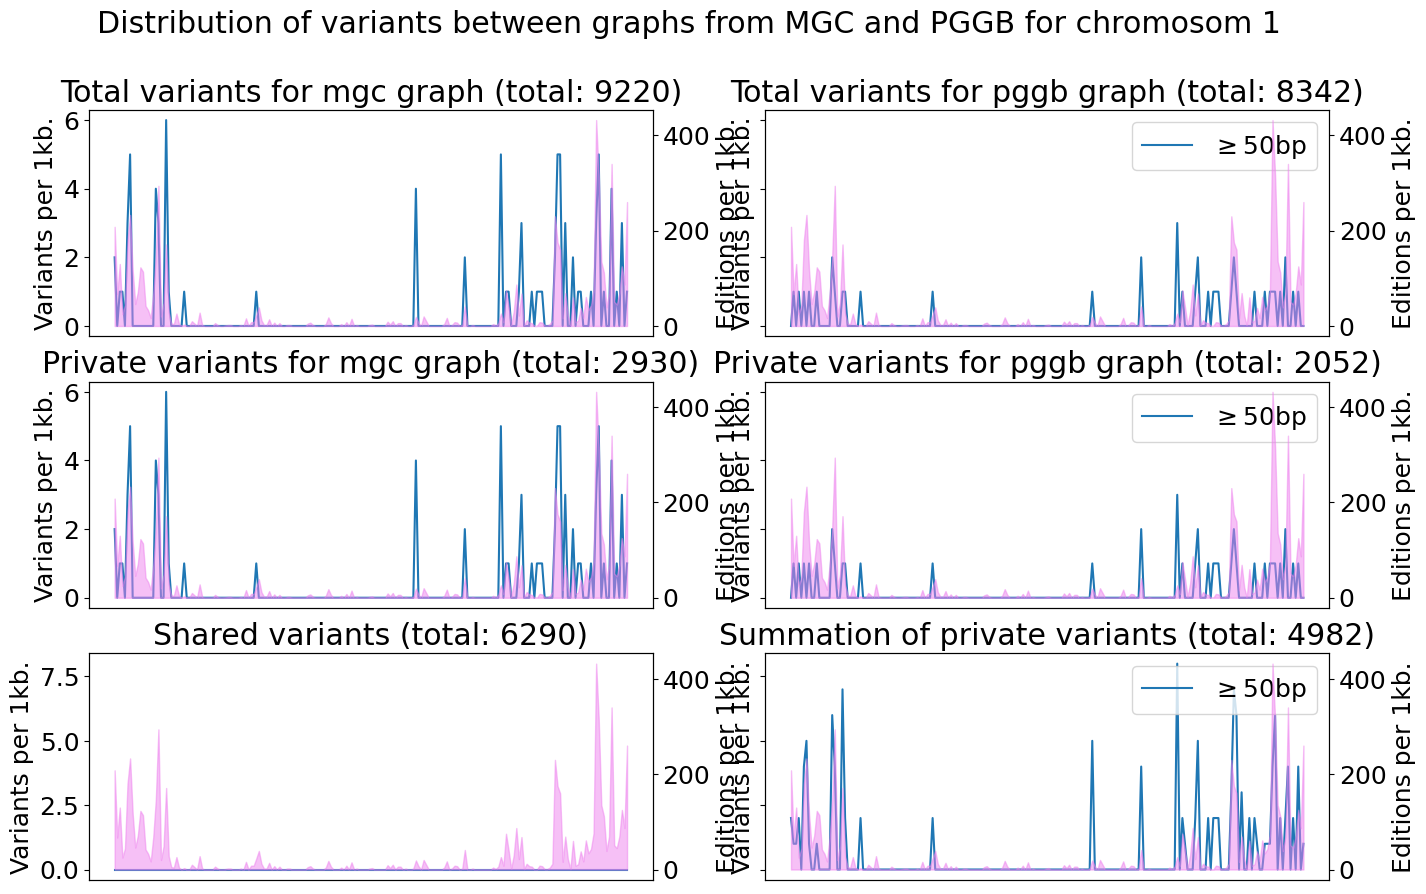

<Figure size 640x480 with 0 Axes>

In [21]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, sharex=True, sharey='row', figsize=(16,10))
fig.suptitle(f"Distribution of variants between graphs from MGC and PGGB for chromosom {chromosom}")

#fig.supylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

alpha = 0.5

for axs in (ax1, ax2, ax3, ax4, ax5, ax6):
    __ = axs.twinx()
    __.fill_between(list(range(sampling)),counts_editions, color= "violet",alpha= alpha)
    __.set_ylabel(f'Editions per {round((reference_length/200)/1000)}kb.')
    axs.set_xticks([])
    axs.set_ylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

ax1.set_title(f"Total variants for mgc graph (total: {sum(counts_A)})")
ax1.plot(counts_A_sup_50)


ax2.set_title(f"Total variants for pggb graph (total: {sum(counts_B)})")
ax2.plot(counts_B_sup_50, label='$\geq$50bp')

ax2.legend(loc='upper right')

ax3.set_title(f"Private variants for mgc graph (total: {sum(p_counts_A)})")
ax3.plot(p_counts_A_sup_50)

ax4.set_title(f"Private variants for pggb graph (total: {sum(p_counts_B)})")
ax4.plot(p_counts_B_sup_50, label='$\geq$50bp')

ax4.legend(loc='upper right')

ax5.set_title(f"Shared variants (total: {sum(counts_A)-sum(p_counts_A)})")
ax5.plot([counts_A_sup_50[i] - p_counts_A_sup_50[i] for i in range(sampling)])

ax6.set_title(f"Summation of private variants (total: {sum(p_counts_A)+sum(p_counts_B)})")
ax6.plot([p_counts_A_sup_50[i] +p_counts_B_sup_50[i] for i in range(sampling)], label='$\geq$50bp')

ax6.legend(loc='upper right')

plt.savefig("figures/baseline_profile.png", bbox_inches='tight')
plt.show()
plt.clf()

We build a dataframe

In [22]:
df_ve:DataFrame = DataFrame(
    data={
        'edition_count':counts_editions,
        'full_total':[(counts_A[i]+counts_B[i])/2 for i in range(sampling)],
        'total_variants_mgc':counts_A,
        'total_variants_mgc_sup_2':counts_A_sup_2,
        'total_variants_mgc_sup_50':counts_A_sup_50,
        'private_variants_mgc':p_counts_A,
        'private_variants_mgc_sup_2':p_counts_A_sup_2,
        'private_variants_mgc_sup_50':p_counts_A_sup_50,
        'total_variants_pggb':counts_B,
        'total_variants_pggb_sup_2':counts_B_sup_2,
        'total_variants_pggb_sup_50':counts_B_sup_50,
        'private_variants_pggb':p_counts_B,
        'private_variants_pggb_sup_2':p_counts_B_sup_2,
        'private_variants_pggb_sup_50':p_counts_B_sup_50,
        'shared_variants':[counts_A[i] - p_counts_A[i] for i in range(sampling)],
        'shared_variants_sup_2':[counts_A_sup_2[i] - p_counts_A_sup_2[i] for i in range(sampling)],
        'shared_variants_sup_50':[counts_A_sup_50[i] - p_counts_A_sup_50[i] for i in range(sampling)],
        'private_variants_sum':[p_counts_A[i]+ p_counts_B[i] for i in range(sampling)],
        'private_variants_sum_sup_2':[p_counts_A_sup_2[i]+ p_counts_B_sup_2[i] for i in range(sampling)],
        'private_variants_sum_sup_50':[p_counts_A_sup_50[i] +p_counts_B_sup_50[i] for i in range(sampling)],
        'mgc_nodes':counts_nodes_cactus,
        'pggb_nodes':counts_nodes_pggb,
        'average_nodes':[(counts_nodes_cactus[i]+counts_nodes_pggb[i])/2 for i in range(sampling)]
    }
)

Then we build correlograms

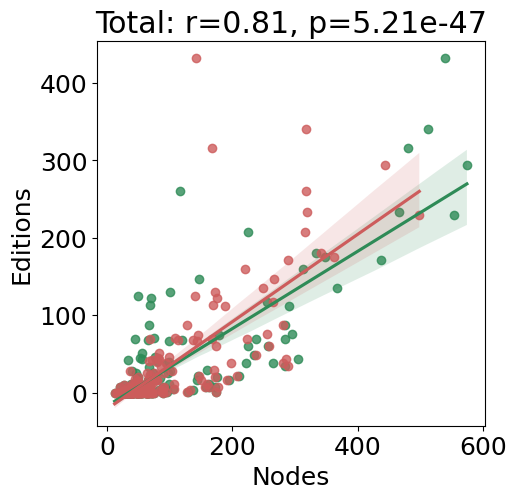

In [23]:
fig, ax = plt.subplots(figsize=(5,5))


ax.set_title(f"Total: r={round(stats.pearsonr(df_ve['average_nodes'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['average_nodes'], df_ve['edition_count'])[1]:.2e}")
regplot(x='mgc_nodes', y='edition_count', data=df_ve, ax=ax, color='seagreen')
regplot(x='pggb_nodes', y='edition_count', data=df_ve, ax=ax, color='indianred')
ax.set_ylabel('Editions')
ax.set_xlabel('Nodes')

plt.savefig("figures/correlograms_nodes.png", bbox_inches='tight')

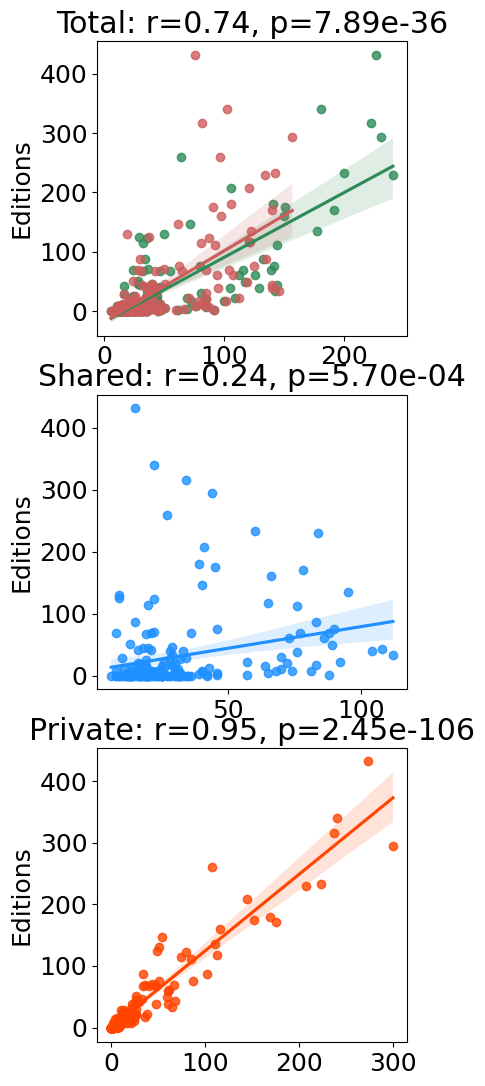

In [24]:
fig, (ax2, ax3, ax4) = plt.subplots(3,1, figsize=(4,13))
#fig.suptitle(f"Correlation between editions and variants between graphs from MGC and PGGB for chromosom {chromosom}")

ax2.set_title(f"Total: r={round(stats.pearsonr(df_ve['full_total'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['full_total'], df_ve['edition_count'])[1]:.2e}")
regplot(x='total_variants_mgc', y='edition_count', data=df_ve, ax=ax2, color='seagreen')
regplot(x='total_variants_pggb', y='edition_count', data=df_ve, ax=ax2, color='indianred')
ax2.set_ylabel('Editions')
ax2.set_xlabel('')

ax3.set_title(f"Shared: r={round(stats.pearsonr(df_ve['shared_variants'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['shared_variants'], df_ve['edition_count'])[1]:.2e}")
regplot(x='shared_variants', y='edition_count', data=df_ve, ax=ax3, color='dodgerblue')
#regplot(x='shared_variants_sup_2', y='edition_count', data=df_ve, ax=ax3)
#regplot(x='shared_variants_sup_50', y='edition_count', data=df_ve, ax=ax3)
ax3.set_ylabel('Editions')
ax3.set_xlabel('')

ax4.set_title(f"Private: r={round(stats.pearsonr(df_ve['private_variants_sum'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['private_variants_sum'], df_ve['edition_count'])[1]:.2e}")
regplot(x='private_variants_sum', y='edition_count', data=df_ve, ax=ax4, color='orangered')
#regplot(x='private_variants_sum_sup_2', y='edition_count', data=df_ve, ax=ax4)
#regplot(x='private_variants_sum_sup_50', y='edition_count', data=df_ve, ax=ax4)
ax4.set_ylabel('Editions')
ax4.set_xlabel('')

plt.savefig("figures/correlograms_editions.png", bbox_inches='tight')

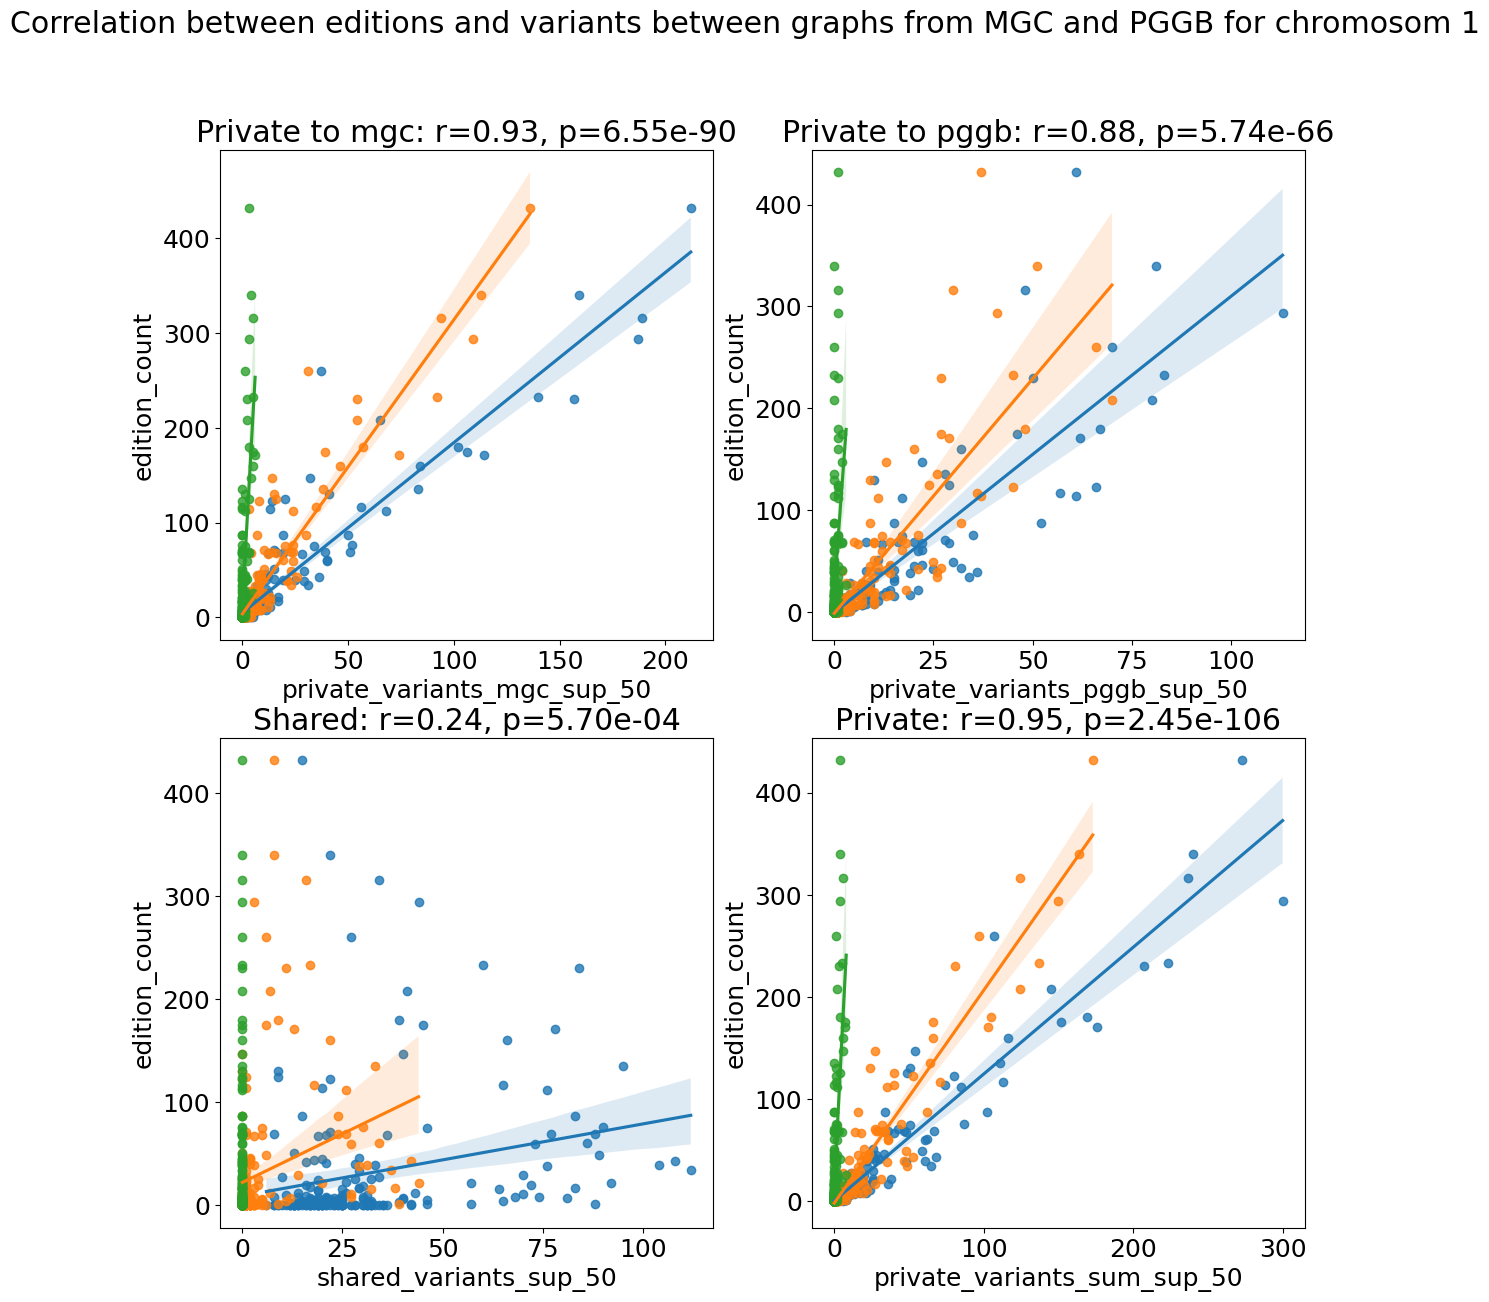

In [25]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14,14))
fig.suptitle(f"Correlation between editions and variants between graphs from MGC and PGGB for chromosom {chromosom}")


ax1.set_title(f"Private to mgc: r={round(stats.pearsonr(df_ve['private_variants_mgc'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['private_variants_mgc'], df_ve['edition_count'])[1]:.2e}")
regplot(x='private_variants_mgc', y='edition_count', data=df_ve, ax=ax1)
regplot(x='private_variants_mgc_sup_2', y='edition_count', data=df_ve, ax=ax1)
regplot(x='private_variants_mgc_sup_50', y='edition_count', data=df_ve, ax=ax1)

ax2.set_title(f"Private to pggb: r={round(stats.pearsonr(df_ve['private_variants_pggb'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['private_variants_pggb'], df_ve['edition_count'])[1]:.2e}")
regplot(x='private_variants_pggb', y='edition_count', data=df_ve, ax=ax2)
regplot(x='private_variants_pggb_sup_2', y='edition_count', data=df_ve, ax=ax2)
regplot(x='private_variants_pggb_sup_50', y='edition_count', data=df_ve, ax=ax2)

ax3.set_title(f"Shared: r={round(stats.pearsonr(df_ve['shared_variants'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['shared_variants'], df_ve['edition_count'])[1]:.2e}")
regplot(x='shared_variants', y='edition_count', data=df_ve, ax=ax3)
regplot(x='shared_variants_sup_2', y='edition_count', data=df_ve, ax=ax3)
regplot(x='shared_variants_sup_50', y='edition_count', data=df_ve, ax=ax3)

ax4.set_title(f"Private: r={round(stats.pearsonr(df_ve['private_variants_sum'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['private_variants_sum'], df_ve['edition_count'])[1]:.2e}")
regplot(x='private_variants_sum', y='edition_count', data=df_ve, ax=ax4)
regplot(x='private_variants_sum_sup_2', y='edition_count', data=df_ve, ax=ax4)
regplot(x='private_variants_sum_sup_50', y='edition_count', data=df_ve, ax=ax4)

plt.savefig("figures/correlograms_variants_classes.png", bbox_inches='tight')

In [26]:
sampling:int = 200

# Comptage des variants dans chacun des graphes (variants totaux)
counts_A_substitutions:list[int] = [0 for _ in range(sampling)]
counts_B_substitutions:list[int] = [0 for _ in range(sampling)]
counts_A_private_substitution:list[int] = [0 for _ in range(sampling)]
counts_B_private_substitution:list[int] = [0 for _ in range(sampling)]

shared_others:list[int] = [0 for _ in range(sampling)]
shared_size_1:list[int] = [0 for _ in range(sampling)]
shared_size_2_9:list[int] = [0 for _ in range(sampling)]
shared_size_10_49:list[int] = [0 for _ in range(sampling)]
shared_size_50:list[int] = [0 for _ in range(sampling)]

ratios:float = sampling/reference_length

with open(private_variants_file_A,'w',encoding='utf-8') as pwriter_A:
    with open(variants_file_A,'r',encoding='utf-8') as reader_A:
        all_lines:list[str] = reader_A.readlines()
        for line in all_lines:
            if line.startswith('#'):
                pwriter_A.write(line)
        for pos in file_A_variants.keys():
            is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
            if any([len(x) == len(file_A_variants[pos][0]) for x in file_A_variants[pos][1].split(',')]):
                counts_A_substitutions[int(int(pos)*ratios)] += 1
                if not is_common_variant:
                    counts_A_private_substitution[int(int(pos)*ratios)] += 1
            if is_common_variant:
                if all([len(x) == 1 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
                    shared_size_1[int(int(pos)*ratios)] += 1
                elif all([len(x) >= 2 and len(x) < 10 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
                    shared_size_2_9[int(int(pos)*ratios)] += 1
                elif all([len(x) >= 10 and len(x) < 50 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
                    shared_size_10_49[int(int(pos)*ratios)] += 1
                elif all([len(x) >= 50 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
                    shared_size_50[int(int(pos)*ratios)] += 1
                else:
                    # We have a variant with multiple sizes
                    shared_others[int(int(pos)*ratios)] += 1
            else:
                for line in all_lines:
                    if not line.startswith('#'):
                        l:list[str] = line.split()
                        if pos == l[1] and file_A_variants[pos] == (l[3],l[4]):
                            pwriter_A.write(line)
                    
with open(private_variants_file_B,'w',encoding='utf-8') as pwriter_B:
    with open(variants_file_B,'r',encoding='utf-8') as reader_B:
        all_lines:list[str] = reader_B.readlines()
        for line in all_lines:
            if line.startswith('#'):
                pwriter_B.write(line)
        for pos in file_B_variants.keys():
            is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
            if any([len(x) == len(file_B_variants[pos][0]) for x in file_B_variants[pos][1].split(',')]):
                counts_B_substitutions[int(int(pos)*ratios)] += 1
                if not is_common_variant:
                    counts_B_private_substitution[int(int(pos)*ratios)] += 1
                    for line in all_lines:
                        if not line.startswith('#'):
                            l:list[str] = line.split()
                            if pos == l[1] and file_B_variants[pos] == (l[3],l[4]):
                                pwriter_B.write(line)

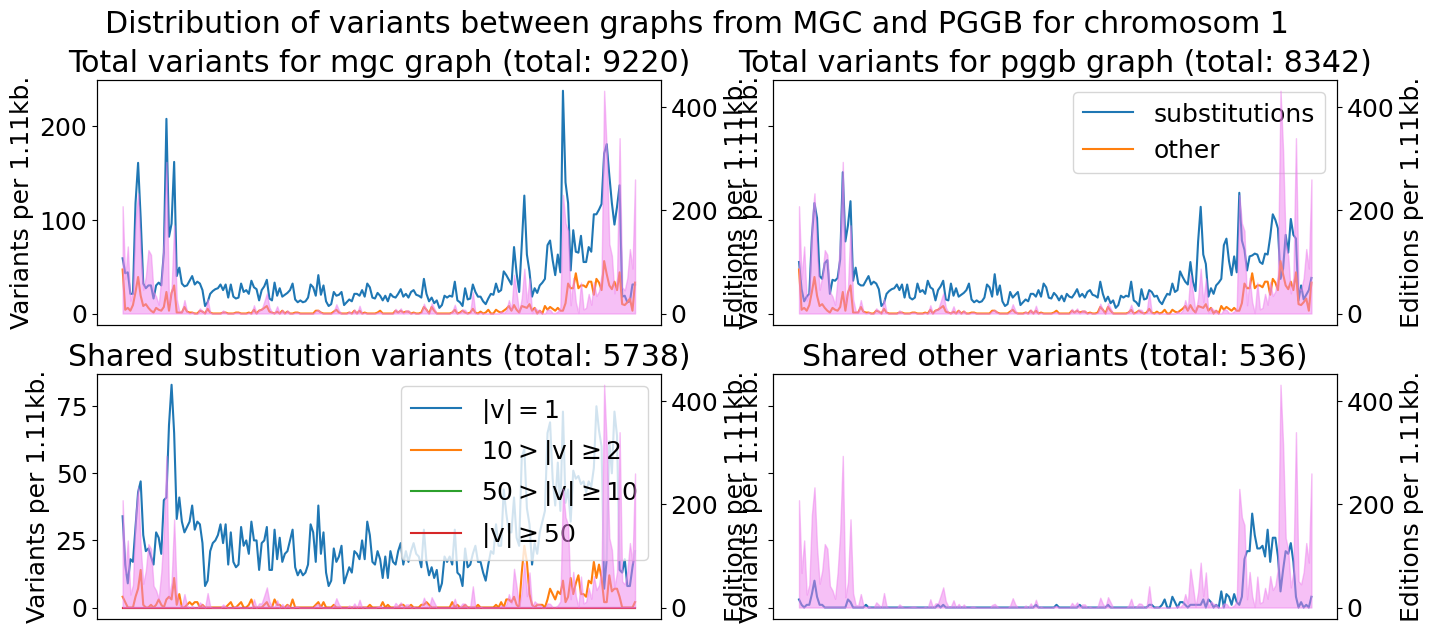

<Figure size 640x480 with 0 Axes>

In [27]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, sharex=True, sharey='row', figsize=(16,7))
fig.suptitle(f"Distribution of variants between graphs from MGC and PGGB for chromosom {chromosom}")

#fig.supylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

alpha = 0.5

for axs in (ax1, ax2, ax3, ax4):
    __ = axs.twinx()
    __.fill_between(list(range(sampling)),counts_editions, color= "violet",alpha= alpha)
    __.set_ylabel(f'Editions per {round((reference_length/200)/1000,2)}kb.')
    axs.set_xticks([])
    axs.set_ylabel(f'Variants per {round((reference_length/200)/1000,2)}kb.')

ax1.set_title(f"Total variants for mgc graph (total: {sum(counts_A)})")
ax1.plot(counts_A_substitutions)
ax1.plot([counts_A[i] - counts_A_substitutions[i] for i in range(sampling)])


ax2.set_title(f"Total variants for pggb graph (total: {sum(counts_B)})")
ax2.plot(counts_B_substitutions, label='substitutions')
ax2.plot([counts_A[i]- counts_A_substitutions[i] for i in range(sampling)], label='other')

ax2.legend(loc='upper right')

# STABLE VARIANTS (shared variants across both graphs)

ax3.set_title(f"Shared substitution variants (total: {sum([counts_A_substitutions[i]- counts_A_private_substitution[i] for i in range(sampling)])})")
ax3.plot(shared_size_1, label='|v|$=$1')
ax3.plot(shared_size_2_9, label='10$>$|v|$\geq$2')
ax3.plot(shared_size_10_49, label='50$>$|v|$\geq$10')
ax3.plot(shared_size_50, label='|v|$\geq$50')

ax3.legend(loc='upper right')

ax4.set_title(f"Shared other variants (total: {sum(shared_others)})")
ax4.plot(shared_others, label='others')

plt.savefig("figures/variants_distribution_types.png", bbox_inches='tight')
plt.show()
plt.clf()